# Helping Hotels in times of flexible bookings

As the pandemic has changed the tourism industry, customers are more and more used to flexibility options and cancellations when it comes to hotel bookings. Hotels are therefore offering their customers more options when it comes to changing and cancelling an existing booking. However, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room.

Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have. By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. This would be a very bad situation. Therefore it can be very beneficial to build a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking, enabling the hotels to overbook the optimal number of rooms. That is the goal of this work.

### Select a performance measure

Classification of singular bookings or regression of rate of cancellations?

- What is the cost of False Positives (we predict cancel, but customers show up and we have filled the slot)? bad
- What is the cost of False Negatives (we predict show up, but customers cancel and we miss to fill the slot)?
- What is the gain of True Positives (we fill the slot and it works out fine)?
- What happens for False negatives (nothing, I suppose)?

--> What can we do with this information?
- choose threshold according to a maximization of profit
- create a custom metric to evaluate our models
- create a custom loss function to build the models


### Check the assumptions

## 0. Imports & Data Access

In [1]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import numpy as np
import os
from datetime import timedelta

plt.style.use('seaborn')
seed = 42

In [2]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df_all = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [3]:
df_all.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

## 1. Data Exploration

In [4]:
df_all.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<AxesSubplot:>

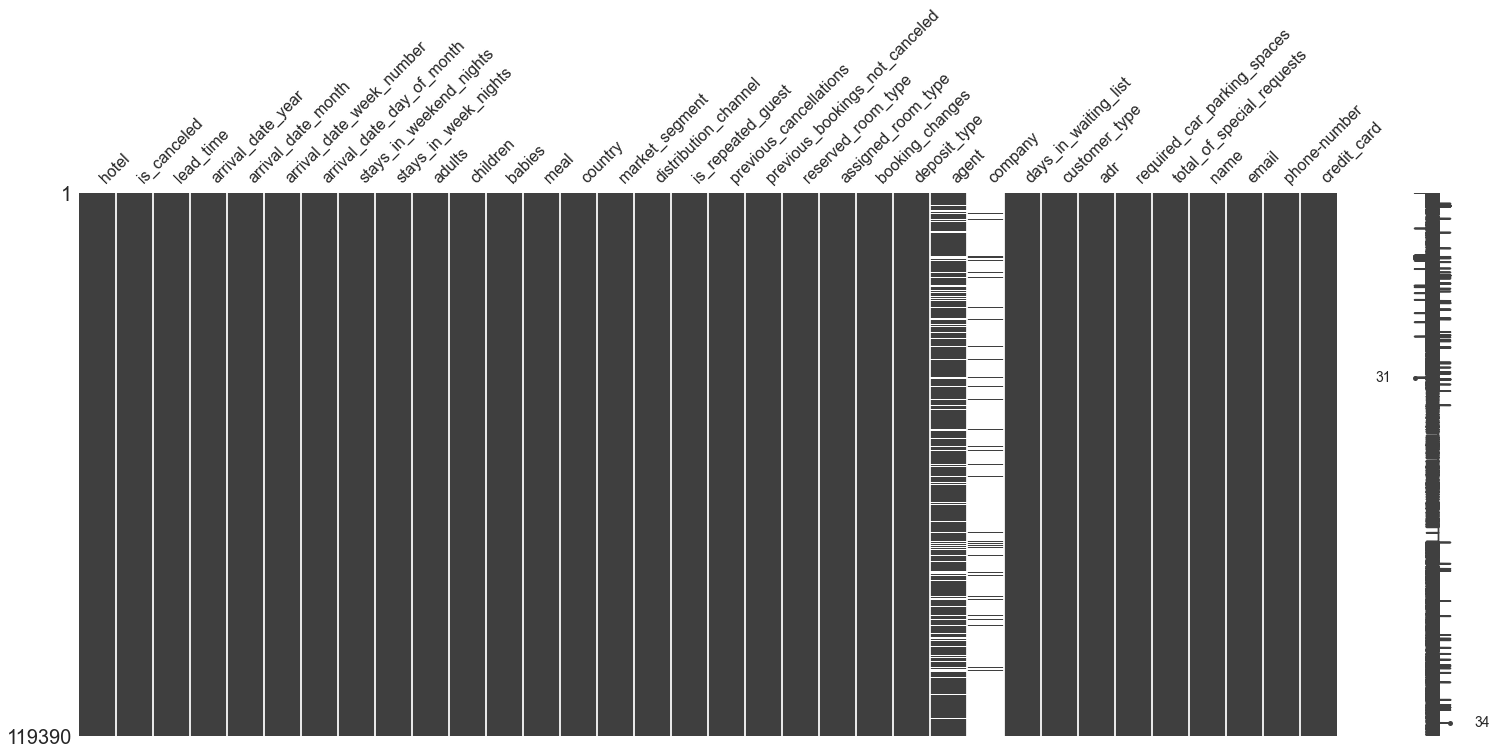

In [46]:
missingno.matrix(df_all)

In [8]:
df_all.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

#### Missing values

Luckily our dataset is complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

#### Data transformation and aggregation. 

Before starting with the EDA we'll transform arrival and booking date to datetime format and transform the type of children in order to facilitate subsequent code operations. <br> We'll also aggregate data by calculating the number of total nights and retrieving the total number of guests. The aim of this is to reduce the number of features by aggregating redundant / similar information.

In [4]:
df_all.dropna(subset=['children'], inplace=True)
df_all['children'] = df_all['children'].astype(int)
df_all = df_all.astype({"country": str})

In [5]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_all['arrival_date_month'] = df_all['arrival_date_month'].apply(lambda m: month_mapping[m])
df_all['arrival_date'] = pd.to_datetime(dict(year = df_all.arrival_date_year, 
                                         month = df_all.arrival_date_month, 
                                         day = df_all.arrival_date_day_of_month))
df_all['booking_date'] = df_all.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df_all['booking_date_day_of_week'] = df_all['booking_date'].dt.weekday

# Number of Guests
df_all['guests'] = df_all['adults'] + df_all['children'] + df_all['babies']

# Length of stay
df_all['stay_total_nights'] = df_all['stays_in_weekend_nights'] + df_all['stays_in_week_nights']

# Is Family
df_all['is_family'] = np.where((df_all['children'] >= 1) | (df_all['babies'] >= 1), 1, 0)

# Assigned room type changed from booked room type
df_all['room_changed'] = np.where(df_all['reserved_room_type'] == df_all['assigned_room_type'], 0, 1)

As a second step, we split the data in a train and a test set before working on the data, because we don't want to influence our training and analysis by any information from the test set.

In [6]:
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(df_all, test_size = 0.2, random_state = seed)

## 2. Exploratory Data Analysis

We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods. 

There are two exceptions here: 
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methdos we use for the 'true' numerical features.
- The 'hotel' feature discribes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels. 

In [23]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,phone-number,credit_card,arrival_date,booking_date,booking_date_day_of_week,guests,stay_total_nights,is_family,room_changed,customer_cluster
67705,City Hotel,1,162,2017,5,18,6,2,1,1,...,178-634-4195,************4817,2017-05-06,2016-11-25,4,1,3,0,0,5
115852,City Hotel,0,65,2017,7,28,10,1,1,2,...,625-113-9294,************3027,2017-07-10,2017-05-06,5,4,2,1,0,2
57349,City Hotel,1,254,2016,9,39,24,1,1,2,...,905-052-7644,************6245,2016-09-24,2016-01-14,3,2,2,0,0,0
11622,Resort Hotel,1,251,2017,5,21,21,2,4,2,...,644-872-9073,************4034,2017-05-21,2016-09-12,0,2,6,0,0,4
33333,Resort Hotel,0,23,2017,2,7,18,1,1,2,...,166-837-7048,************1922,2017-02-18,2017-01-26,3,2,2,0,0,3


In [13]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)

categorical_features.append('is_canceled')
df_cat = df[categorical_features]

### 2.1 Numerical features
#### 2.1.1 Correlations

First we'll take a lookt at collinearity in the data set, by pairplotting relevant features and calculating their correlations.

Please note that we are only using aggregated features here and not the features we calculated these aggregated ones on. For example, it wouldn't make sense to check for collinearity in guests with adults, children or babies as these variables are obviously correlated and won't be used side by side in the model. 

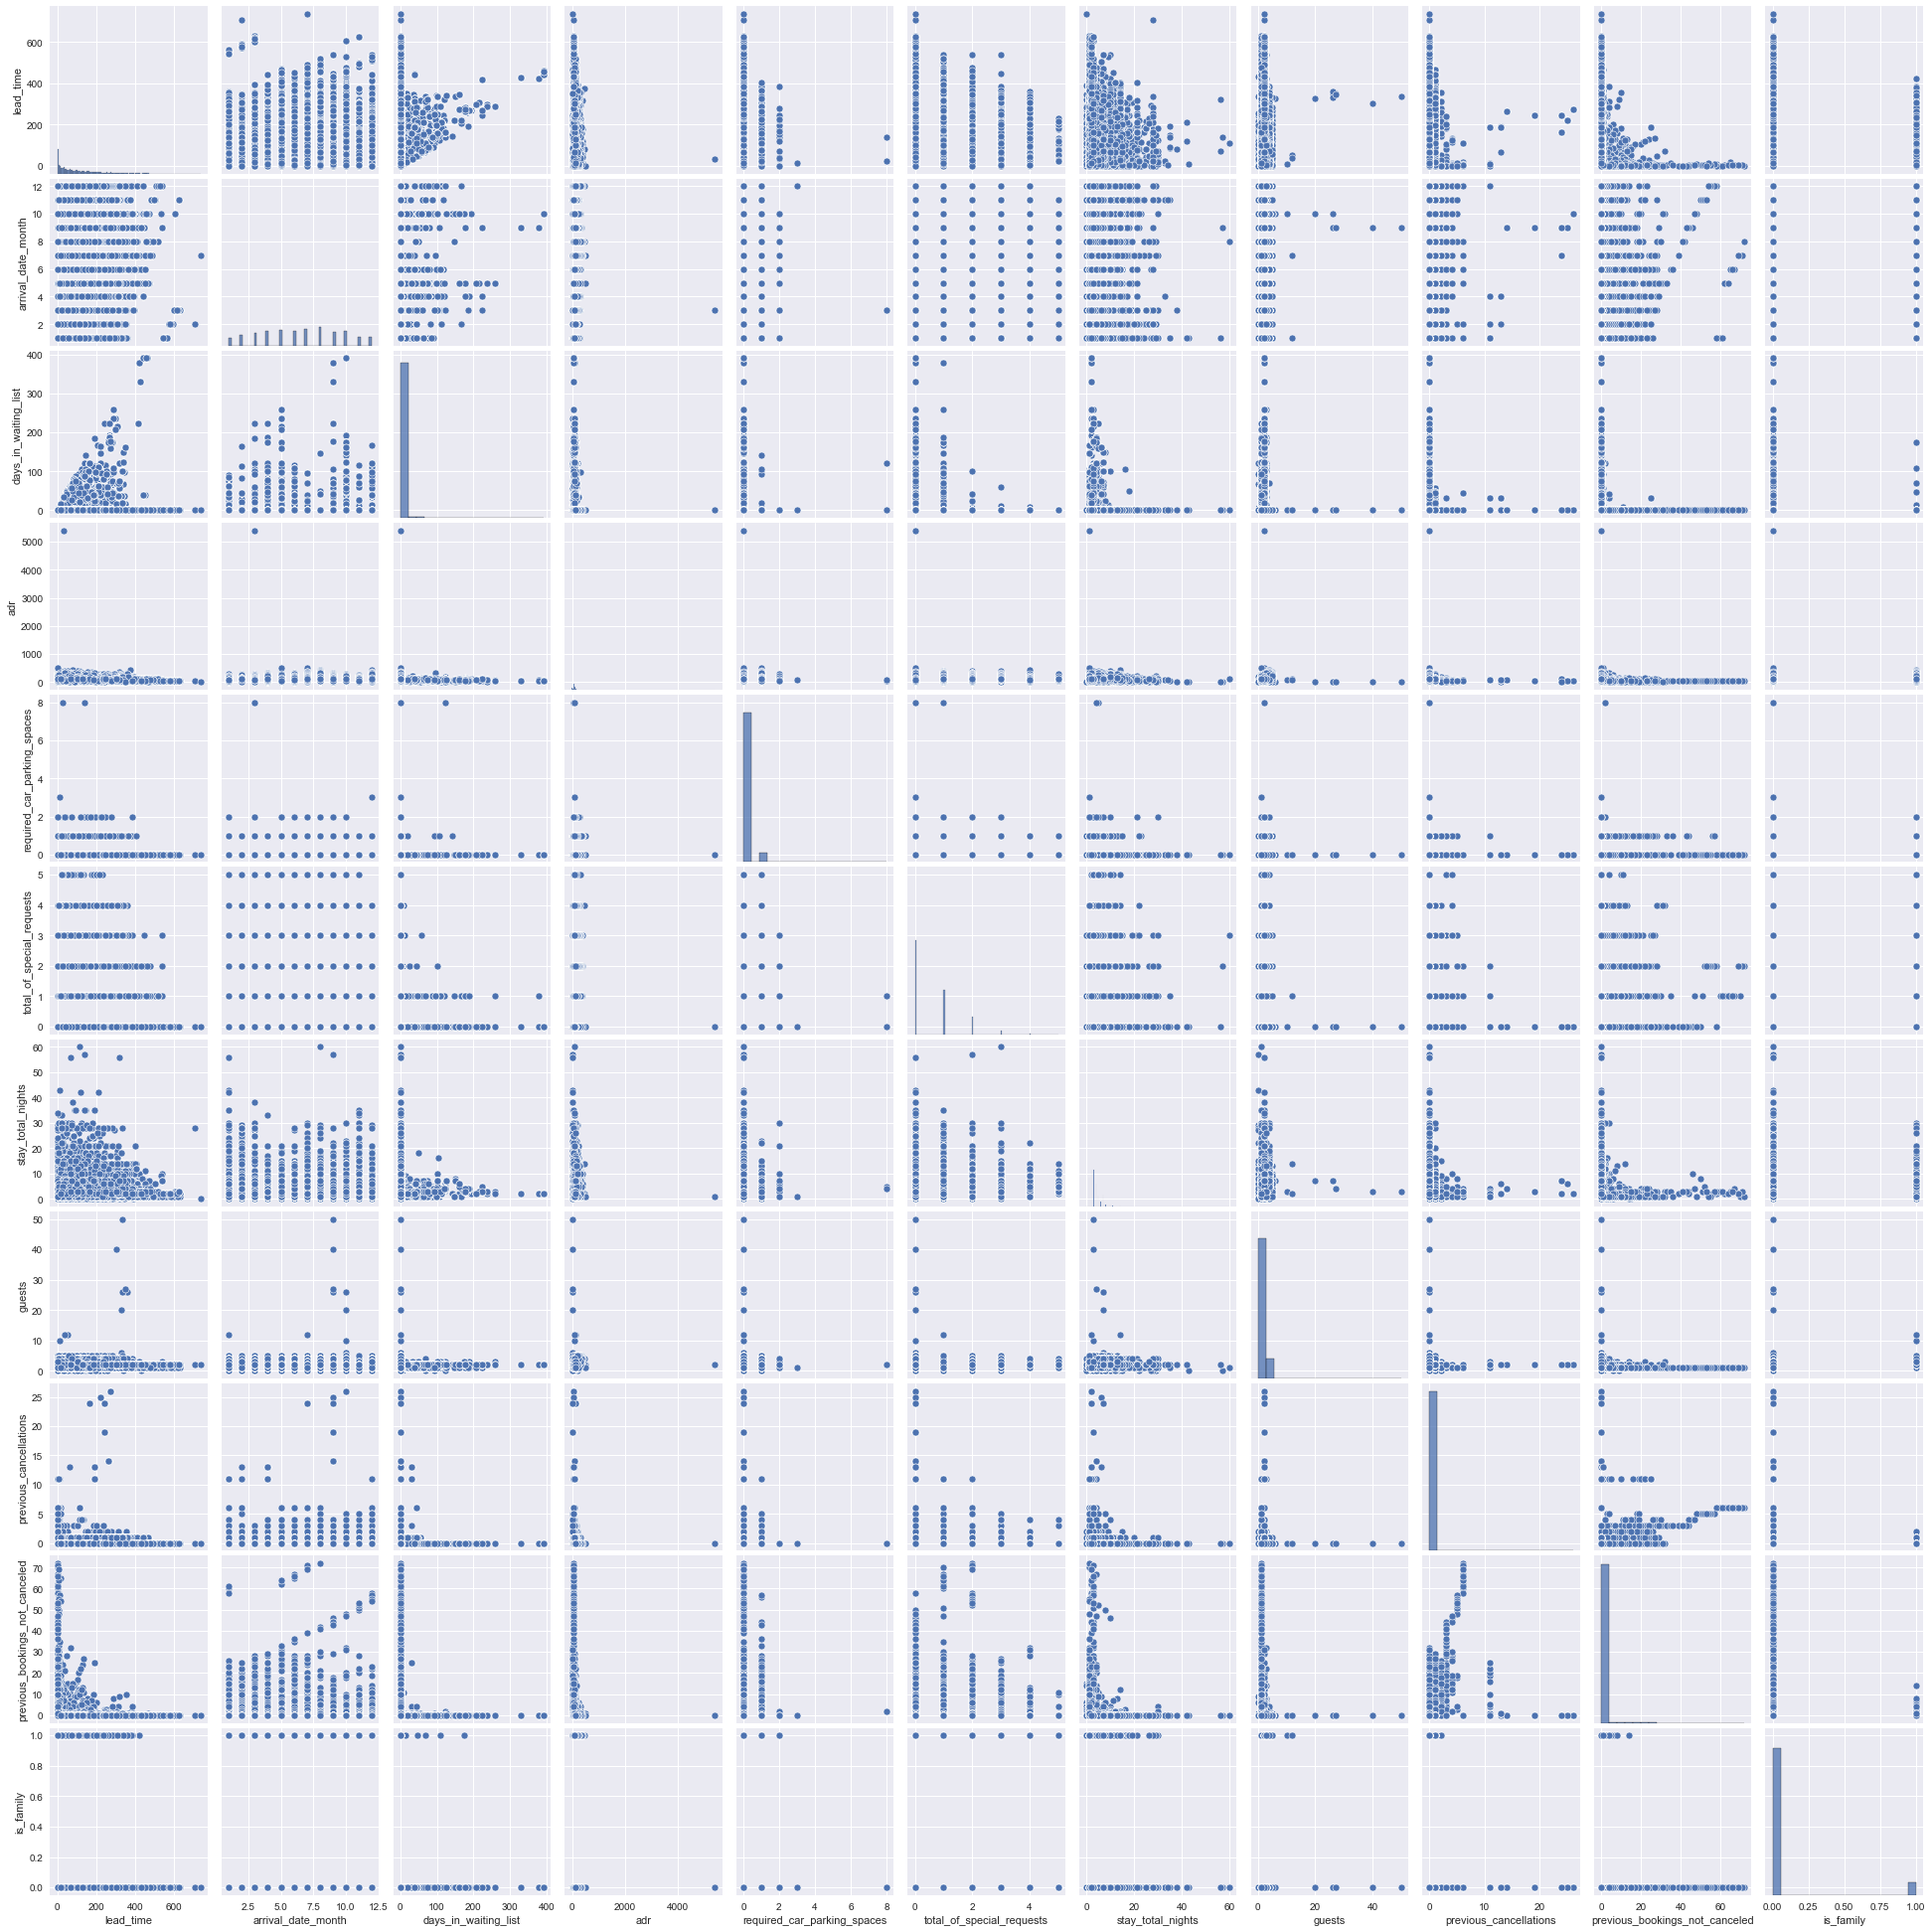

In [14]:
sns.pairplot(data=df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']])
plt.show(sns)

In [16]:
df_corr = pd.DataFrame(df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr().unstack()).rename({0: 'correlation'}, axis=1)
df_corr[df_corr['correlation'] != 1].sort_values(by='correlation')

,,correlation
lead_time,required_car_parking_spaces,-0.116711
required_car_parking_spaces,lead_time,-0.116711
previous_bookings_not_canceled,guests,-0.099201
guests,previous_bookings_not_canceled,-0.099201
lead_time,total_of_special_requests,-0.095074
...,...,...
is_family,adr,0.299004
adr,guests,0.367858
guests,adr,0.367858
is_family,guests,0.578608


The highest correlation among our features is the correlation of ADR (revenue per day) with the number of guests, this follows the logic that with the more people you stay in a hotel, the more you'll spend. When building the model we'll take a closer look if this becomes a problem. For the other features the correlations are really small and therefore no worry.  

Now, lets get the correlations of the **label** with the features, separately for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [17]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.292656,0.308682,0.228891
previous_cancellations,0.109884,0.169672,0.113671
adults,0.058182,0.050137,0.080657
days_in_waiting_list,0.053556,0.059925,-0.035325
adr,0.045862,-0.011694,0.106725
guests,0.044909,0.020516,0.103634
booking_date_day_of_week,0.034550,0.029820,0.027280
stays_in_week_nights,0.027089,0.049029,0.082916
stay_total_nights,0.019909,0.034837,0.087697


This already gives a good indication, but let's plot the data to make the difference easier to understand.

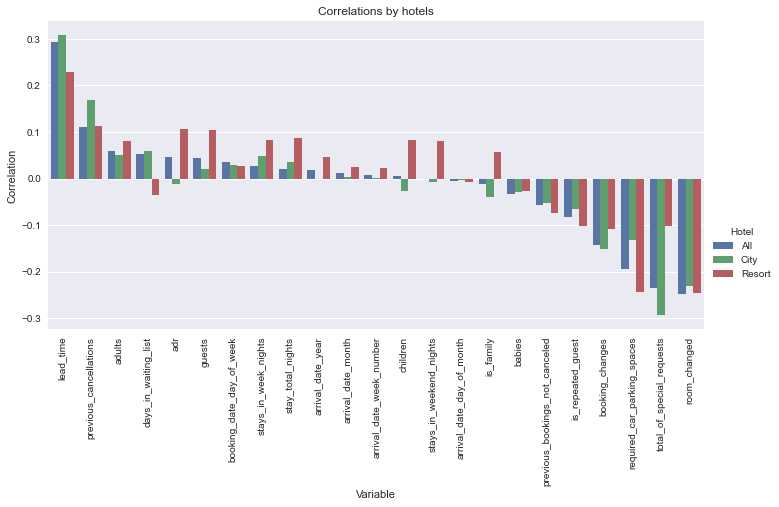

In [18]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel. 

Based on this observation we will try out when building our first models, wether separate models or a joint model for both hotels performs better. 

As booking changes cumulates over time the dataset doesn't include the information when the last change was made, we will not use it in our model. By this we prevent information that might have appeared just days before the arrival from influencing our model whith wich we want to predict cancelations at least 7 days before (the exact number will be deiced later on). 

Some numeric variables can also be used in binary form, which could benefit the model's performance. In order to find out which option should be picked, we will look at the correlations with the target variable is_canceled. Let's first look at total_of_special requests.

In [15]:
df_corrcheck = df
df_corrcheck['any_requests'] = df_corrcheck.total_of_special_requests.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_requests', 'total_of_special_requests']].corr()

,is_canceled,any_requests,total_of_special_requests
is_canceled,1.000000,-0.264282,-0.235280
any_requests,-0.264282,1.000000,0.862319
total_of_special_requests,-0.235280,0.862319,1.000000


As the binary variable any_requests is more correlated with is_canceled, we will choose this option later on. Now let's inspect previous_canellations.

In [16]:
df_corrcheck['any_cancelations'] = df_corrcheck.previous_cancellations.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_cancelations', 'previous_cancellations']].corr()

,is_canceled,any_cancelations,previous_cancellations
is_canceled,1.000000,0.270280,0.109884
any_cancelations,0.270280,1.000000,0.430262
previous_cancellations,0.109884,0.430262,1.000000


This correlation is significantly higher in binary form. We will therefore use it in our model. Next up: required_car_parking_spaces.

In [17]:
df_corrcheck['any_parking'] = df_corrcheck.required_car_parking_spaces.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_parking', 'required_car_parking_spaces']].corr()

,is_canceled,any_parking,required_car_parking_spaces
is_canceled,1.000000,-0.197058,-0.194928
any_parking,-0.197058,1.000000,0.989192
required_car_parking_spaces,-0.194928,0.989192,1.000000


There is only little difference between the binary and the numeric column. We will go for the binary variable to keep the model simpler.

#### 2.1.2 Frequency Distributions

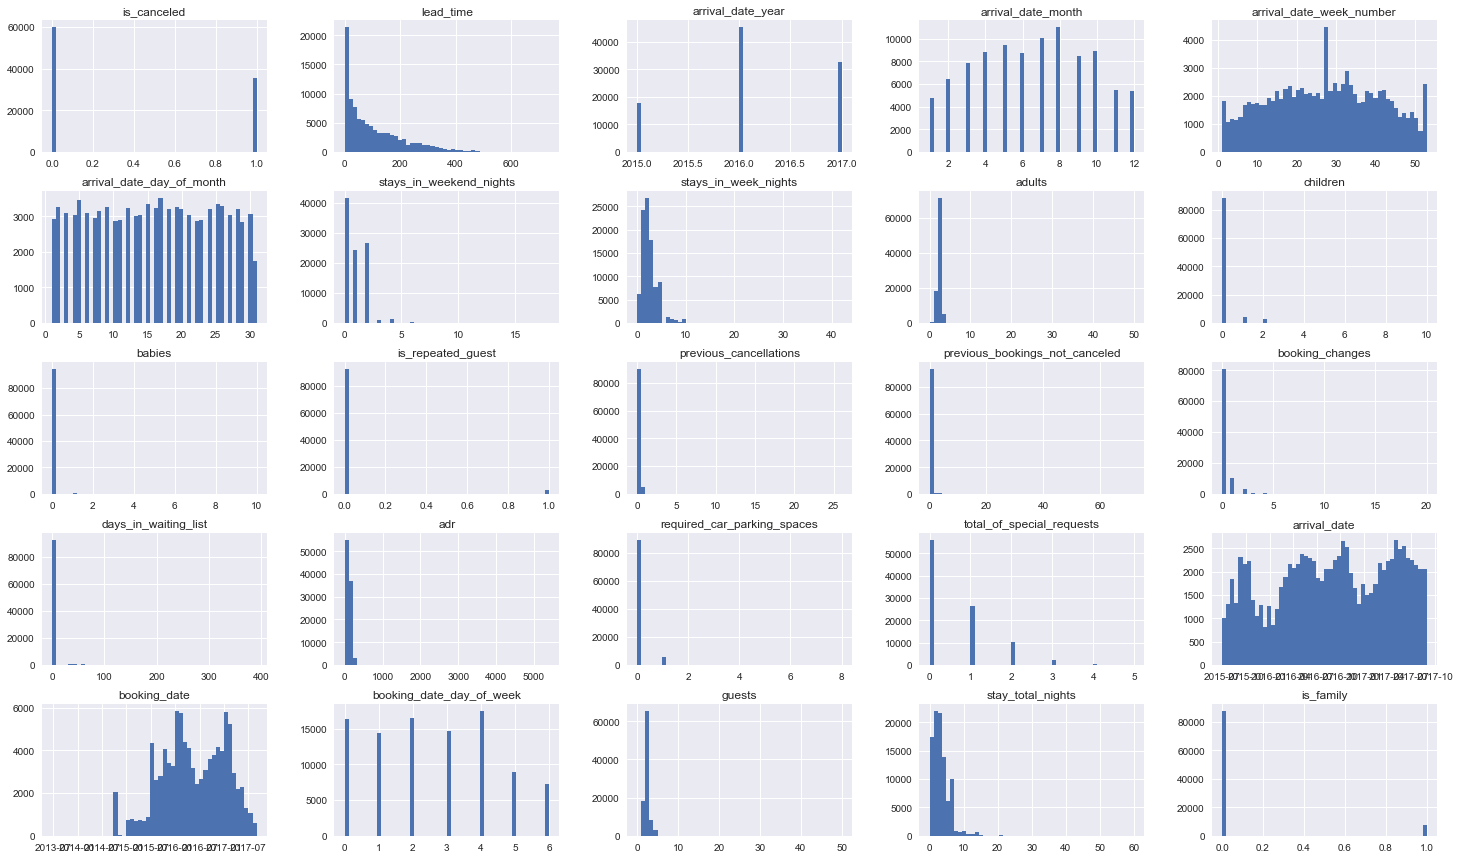

In [18]:
df_num.hist(bins=50, figsize=(25,15))
plt.show()

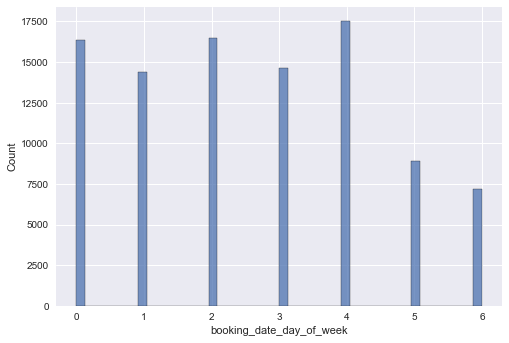

In [20]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

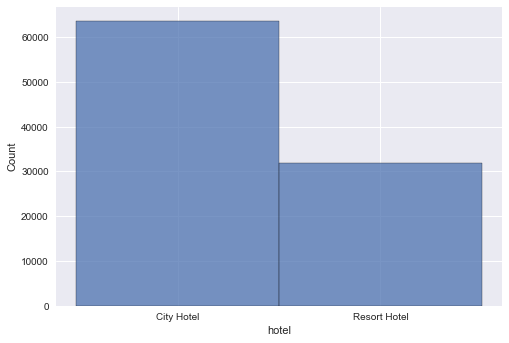

In [21]:
sns.histplot(df['hotel'])
plt.show(sns)

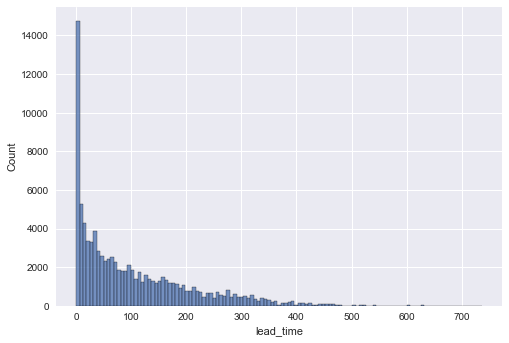

In [22]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

Here we'll use df_cat, with all categorical features we have identified perviously. 

In [23]:
df_cat.columns

Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'company', 'customer_type', 'is_canceled'],
      dtype='object')

'Company' and 'agent' are columns with ids. Let's look at the values in the other ("true") categorical variables to get a feeling for what they are. 

In [24]:
df_cat[['meal']].value_counts(normalize = True)

meal     
BB           0.773255
HB           0.121215
SC           0.089123
Undefined    0.009800
FB           0.006607
dtype: float64

In [25]:
df_cat[['country']].value_counts(normalize = True).head(10)

country
PRT        0.407013
GBR        0.101133
FRA        0.086998
ESP        0.071774
DEU        0.061063
ITA        0.031798
IRL        0.028280
BEL        0.019852
BRA        0.018763
USA        0.017674
dtype: float64

In [26]:
df_cat[['market_segment']].value_counts(normalize = True)

market_segment
Online TA         0.473667
Offline TA/TO     0.203208
Groups            0.165421
Direct            0.105017
Corporate         0.044269
Complementary     0.006418
Aviation          0.002000
dtype: float64

In [27]:
df_cat[['distribution_channel']].value_counts(normalize = True)

distribution_channel
TA/TO                   0.820549
Direct                  0.122147
Corporate               0.055650
GDS                     0.001654
dtype: float64

In [28]:
df_cat[['reserved_room_type']].value_counts(normalize = True)

reserved_room_type
A                     0.720076
D                     0.161599
E                     0.054844
F                     0.023956
G                     0.017339
B                     0.009423
C                     0.007664
H                     0.004952
P                     0.000094
L                     0.000052
dtype: float64

In [29]:
df_cat[['assigned_room_type']].value_counts(normalize = True)

assigned_room_type
A                     0.620315
D                     0.212673
E                     0.065534
F                     0.031149
G                     0.021297
C                     0.019695
B                     0.017946
H                     0.005958
I                     0.003057
K                     0.002283
P                     0.000094
dtype: float64

In [30]:
df_cat[['deposit_type']].value_counts(normalize = True)

deposit_type
No Deposit      0.876660
Non Refund      0.121916
Refundable      0.001424
dtype: float64

In [31]:
df_cat[['customer_type']].value_counts(normalize = True)

customer_type  
Transient          0.750743
Transient-Party    0.210380
Contract           0.034008
Group              0.004869
dtype: float64

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [32]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat = df_cat.sort_index().reset_index(drop = True)
df_cat_trans = pd.DataFrame(data = onehot.fit_transform(df_cat.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names_out())

In [33]:
df_cat_trans = pd.concat([df_cat.is_canceled, df_cat_trans], axis = 1 )


Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [35]:
df_cat_corr = df_cat_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

In [36]:
df_cat_corr.sort_values()

deposit_type_No Deposit         -0.477762
market_segment_Direct           -0.153217
distribution_channel_Direct     -0.150596
assigned_room_type_D            -0.127559
customer_type_Transient-Party   -0.125246
                                   ...   
assigned_room_type_A             0.197833
market_segment_Groups            0.221364
country_PRT                      0.336209
deposit_type_Non Refund          0.481499
is_canceled                      1.000000
Name: is_canceled, Length: 870, dtype: float64

This is gives a dataframe of **xxxx** correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

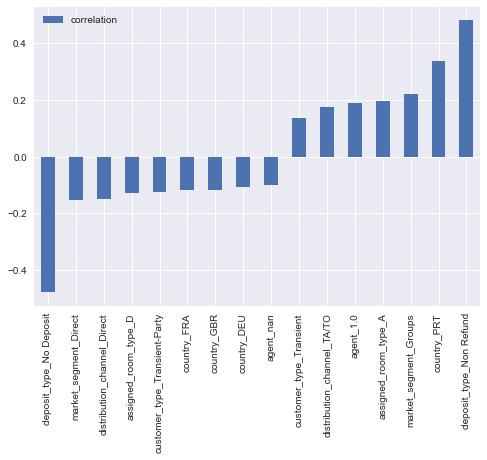

In [37]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x1 = ('Coutnry') equalling to Portugal, x2 (= 'market_segment') equalling to Groups can be important when building the model.

### 2.3 Time Series Analysis
In this section we are looking for underlying seasonality in the given cancelations and bookings.

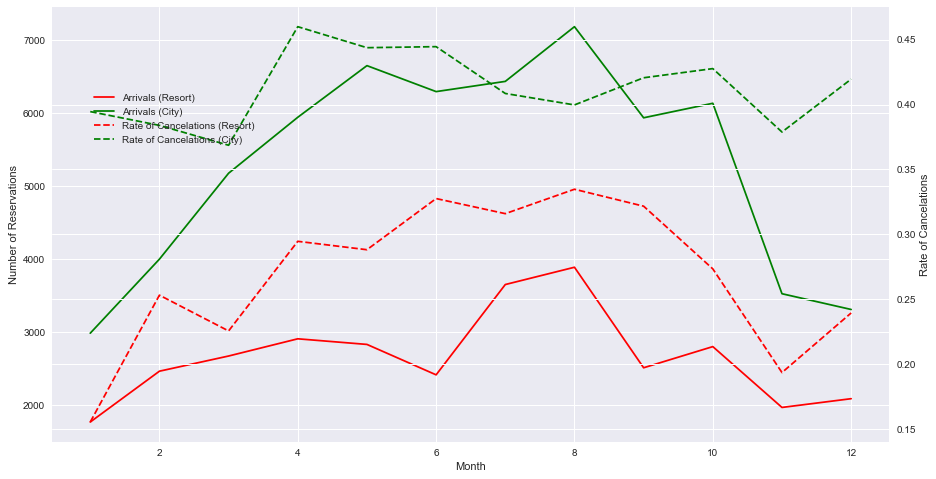

In [38]:
df_resort = df[df["hotel"] == "Resort Hotel"]
df_city = df[df["hotel"] == "City Hotel"]

#Get data for Resort Hotel
df_timeseries_r = pd.DataFrame(df_resort.groupby("arrival_date_month").size())
df_timeseries_r["Cancelations"] = df_resort.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_r.columns = ['Arrivals', 'Cancelations']
df_timeseries_r["Cancelation_Share"] = df_timeseries_r["Cancelations"]/df_timeseries_r["Arrivals"]

#Get data for City Hotel
df_timeseries_c = pd.DataFrame(df_city.groupby("arrival_date_month").size())
df_timeseries_c["Cancelations"] = df_city.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_c.columns = ['Arrivals', 'Cancelations']
df_timeseries_c["Cancelation_Share"] = df_timeseries_c["Cancelations"]/df_timeseries_c["Arrivals"]

#Plot linechart
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Reservations")
ax1.plot(
    df_timeseries_r["Arrivals"],
    color="red",
    label="Arrivals (Resort)"
)

ax1.plot(
    df_timeseries_c["Arrivals"],
    color="green",
    label="Arrivals (City)"
)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("Rate of Cancelations")
ax2.plot(
    df_timeseries_r["Cancelation_Share"],
    color="red",
    linestyle="dashed",
    label="Rate of Cancelations (Resort)",
)

ax2.plot(
    df_timeseries_c["Cancelation_Share"],
    color="green",
    linestyle="dashed",
    label="Rate of Cancelations (City)",
)

fig.legend(loc = 2, borderaxespad=9)

Based on this plot, we can draw several conclusions:

- Bookings and cancelation-rate differs greatly between Resort and City Hotels. With City Hotels experiencing more bookings but also more cancellations.
- Cancellation rate follows the same patten as the number of bookings.
- Bookings and cancellations follow a seasonal pattern.

## 3. Feature Selection
In this section we want to select relevant features for model creation.

First, we will preprocess all features according to a pipeline.
Then, we will apply different feature selection methods: statistics based feature selection and tree based feature selection.

### 3.1 Feature Selection Pipeline
In this step the numerical features are standard scaled. For the categorical features, dimensions with less than 5% occurences are aggregated in a 'other' category. Subsequently, categories are one-hot-encoded. The features *booking_changes* and *deposit_type* are excluded from the feature selection due to their inadequateness depicted in *2*.

In [430]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, FunctionTransformer, StandardScaler, OneHotEncoder

num_features = ['lead_time', 'adr', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'stays_in_weekend_nights', 'stay_total_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'total_of_special_requests', 'room_changed']

cat_features = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type']

class replace_other(TransformerMixin):
    """Replaces every value that accounts for less than 5% of the count of all unique
    values in the column with 'Other'"""

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, df):
        for col in df.columns:
            counts = df[col].value_counts(normalize=True)
            irrelevant = counts[counts < 0.05].index.tolist()
            df[col] = df[col].apply(lambda v: 'Other' if v in irrelevant else v)
        return df

    def get_feature_names_out(self, col_names):
        return col_names

cat_selection_pipeline = Pipeline(steps=[
    ('replace_other', replace_other()),
    ('encoder', OneHotEncoder(sparse=False))
])

feature_selection_pipeline = ColumnTransformer(transformers=[
    ('numeric', StandardScaler(), num_features),
    ('categorical', cat_selection_pipeline, cat_features)
])

In [431]:
feature_selection_df = pd.DataFrame(data=feature_selection_pipeline.fit_transform(df), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_df

,numeric__lead_time,numeric__adr,numeric__arrival_date_month,numeric__arrival_date_week_number,numeric__arrival_date_day_of_month,numeric__stays_in_week_nights,numeric__stays_in_weekend_nights,numeric__stay_total_nights,numeric__adults,numeric__children,...,categorical__reserved_room_type_D,categorical__reserved_room_type_E,categorical__reserved_room_type_Other,categorical__assigned_room_type_A,categorical__assigned_room_type_D,categorical__assigned_room_type_E,categorical__assigned_room_type_Other,categorical__customer_type_Other,categorical__customer_type_Transient,categorical__customer_type_Transient-Party
0,0.542409,-0.427015,-0.502248,-0.673372,-1.113991,-0.786595,1.077020,-0.165988,-1.498383,-0.260381,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.364575,1.628262,0.144601,0.061288,-0.658664,-0.786595,0.074652,-0.557793,0.251740,4.764054,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.402640,-0.113830,0.791450,0.869414,0.934982,-0.786595,0.074652,-0.557793,0.251740,-0.260381,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.374589,-0.237146,-0.502248,-0.452974,0.593486,0.788563,1.077020,1.009425,0.251740,-0.260381,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.757289,-1.162413,-1.472522,-1.481498,0.251991,-0.786595,0.074652,-0.557793,0.251740,-0.260381,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95503,-0.944296,0.081911,0.468026,0.502084,0.479654,-0.786595,-0.927716,-0.949597,0.251740,2.251837,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
95504,-0.345874,0.121059,-0.825673,-0.820304,0.707318,-0.786595,1.077020,-0.165988,0.251740,-0.260381,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
95505,-0.009262,0.219908,1.761724,1.897937,1.276477,0.263510,-0.927716,-0.165988,2.001863,-0.260381,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
95506,0.243198,0.367692,0.468026,0.281686,-1.683151,1.313616,1.077020,1.401230,0.251740,-0.260381,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### 3.2 Recursive Feature Elimination

In [432]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=15, step=5)
selector.fit(feature_selection_df, df['is_canceled'])

RFE(estimator=RandomForestClassifier(), n_features_to_select=15, step=5)

In [433]:
feat_rank_df = pd.DataFrame(data=selector.ranking_, index=feature_selection_df.columns, columns=['rank']).sort_values('rank', ascending=True)
feat_rank_df

,rank
numeric__lead_time,1
categorical__customer_type_Transient,1
categorical__country_PRT,1
numeric__previous_cancellations,1
categorical__market_segment_Groups,1
categorical__market_segment_Online TA,1
numeric__total_of_special_requests,1
numeric__room_changed,1
numeric__stays_in_weekend_nights,1
numeric__stays_in_week_nights,1


Let's look at the relative importance of the remaining 15 features in a Random Forest:

In [434]:
remaining_features = feature_selection_df.columns[selector.support_]
feature_selection_remainder_df = feature_selection_df[remaining_features]
rf_feature_selection = RandomForestClassifier()
rf_feature_selection.fit(feature_selection_remainder_df, df['is_canceled'])
importances_df = pd.DataFrame(data=rf_feature_selection.feature_importances_, index=remaining_features, columns=['Importance']).sort_values('Importance', ascending=False)
importances_df

,Importance
numeric__lead_time,0.203632
numeric__adr,0.137911
categorical__country_PRT,0.104149
numeric__arrival_date_day_of_month,0.083421
numeric__arrival_date_week_number,0.071397
numeric__total_of_special_requests,0.069940
categorical__market_segment_Online TA,0.050861
numeric__room_changed,0.042354
numeric__stay_total_nights,0.041968
numeric__previous_cancellations,0.039718


<AxesSubplot:>

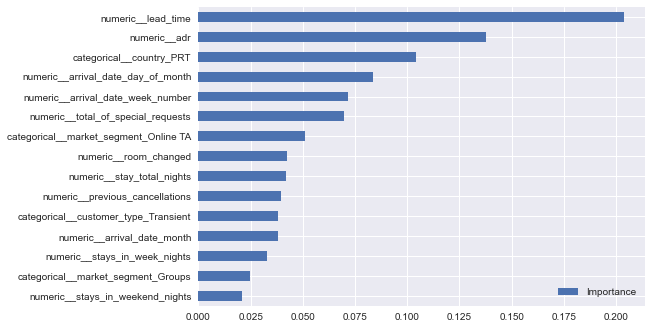

In [435]:
importances_df.sort_values('Importance', ascending=True).plot.barh()

In [437]:
df['market_segment'].value_counts(normalize=True)

Online TA        0.473667
Offline TA/TO    0.203208
Groups           0.165421
Direct           0.105017
Corporate        0.044269
Complementary    0.006418
Aviation         0.002000
Name: market_segment, dtype: float64

The two clearly most important features are the lead time and the average daily revenue (adr). The remaining features all have a pretty low, but balanced, importance that remains above the 2% mark.

**Potential Clustering of Customers:**
<br>We've noticed that most of the features that characterize different customer types, such as the room and meal chosen, the group size, or whether the customer is a family or not, are not among the top 15 features. Thus, we've tried to form different clusters to combine all these features into a single *customer_cluster* feature. Our approach (documented in appendix 5.2), did not lead to relevant model performance improvement while increasing computing times and model complexity substantially. Therefore, we decided to not include the different customer clusters and instead include selected binarized features, such as *is market segment Online TA*.

**Conclusion:**
- *lead_time* will be included in model
- *Non Refund* and *Non Deposit* seem to be strong features bue are not included due to the flaws and potential data errors explained in 2.
- *adr* will be included in model
- For *country*, only a binary variable *country_PRT* will be included in the model
- *total_of_special_requests* will be included in the model
- For *market_segment* we can see that *Online TA* has a high importance and also makes up almost half of the values in that column. Besides *Online TA*, also *Groups* forms a relevant fraction of all values and has substantial importance. Thus, for market segment, the binary columns *market_segment_Online TA* and *market_segment_Groups* will be included in the model
- As temporal dimensions, *arrival_date_day_of_month*, *arrival_date_month* and *arrival_date_week_number* will be included
- *previous_cancellations* will be included in the model
- Binary feature *room_changed* will be included in the model
- *stay_total_nights* will be included in the model (due to co-linearity, *stays_in_week_nights* will not be included)
- *customer_type_transient* will be included in the model
<br>All other features will be disregarded due to potential information duplication or irrelevance.

## 4. Model Creation
### 4.1 Preprocessing Pipeline
For the features chosen in 3.3, a preprocessing pipeline is built in which features get standardized or binarized.

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

In [438]:
#Define categories of attributes
num_attribs = ["lead_time", "adr", "stay_total_nights"]
num_attribs_discr = ["arrival_date_day_of_month", "arrival_date_month", "arrival_date_week_number", "room_changed"]
num_attribs_bin = ["total_of_special_requests", "previous_cancellations"]
cat_attribs_bin = [
    # (column, true value)
    ("country", "PRT"),
    ("market_segment", "Online TA"),
    ("market_segment", "Groups"),
    ("customer_type", "Transient")
]

# Create a class to select specified columns from DataFrame
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Define function for one-vs-all binary transformation of categorical variables
def binary_tansformer_cat(arr, true_vals):
    # order of true_vals needs to be equivalent to corresponding column names in cat_attribs_bin
    for i, true_val in enumerate(true_vals):
        arr[:, i] = np.where(arr[:, i] == true_val, 1, 0)
    return arr

num_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs)),
        ('scaler', StandardScaler())
    ])

num_discrete_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_discr))
    ]
)

num_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_bin)),
        ('binarizer', Binarizer())
    ])

cat_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector([e[0] for e in cat_attribs_bin])),
        ('binarizer_cat', FunctionTransformer(binary_tansformer_cat, kw_args={'true_vals': [e[1] for e in cat_attribs_bin]}))
    ])

preprocessor = FeatureUnion(
    transformer_list = [
        ('num_pipeline', num_pipeline),
        ("num_discrete_pipeline", num_discrete_pipeline),
        ("num_binary_pipeline", num_binary_pipeline),
        ("cat_binary_pipeline", cat_binary_pipeline),
#        ("cat_pipeline", cat_pipeline)
    ])
preprocessor

FeatureUnion(transformer_list=[('num_pipeline',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(attribute_names=['lead_time',
                                                                                 'adr',
                                                                                 'stay_total_nights'])),
                                                ('scaler', StandardScaler())])),
                               ('num_discrete_pipeline',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(attribute_names=['arrival_date_day_of_month',
                                                                                 'arrival_date_month',
                                                                                 'arrival_date_week_number',
                                                                                 'r

### 4.2 Creation of X_train, y_train, X_test, y_test
For the subsequent modeling, we need uniform datasets for training and testing data. Therefore, we split the existent 'df' (training data), 'df_test' (testing data) into X (features) and y (labels). The features are passed through the preprocessing pipeline.

In [439]:
set_config(display='text')
X_train = preprocessor.fit_transform(df)
y_train = df['is_canceled']
X_test = preprocessor.fit_transform(df_test)
y_test = df_test['is_canceled']

### 4.3 Standardized Model Evaluation
We define several functions to evaluate a model. The aim is to have standardized functions to compare the various models on.

In [21]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, roc_curve
import seaborn as sns

def get_cnf_matrix(y_true, y_pred):
    """
    This function receives a true y and a predicted y array. It plots a confusion matrix as sns.heatmap.
    
    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values. 
        y_pred:
            numpy array or pandas Series / DF of predicted y values. 
    """

    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix

    class_names=[0,1]
    fig, ax = plt.subplots(figsize=(3.5,2.8), dpi=105)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix),
                annot=True,
                cmap="YlGnBu" ,
                fmt='g',
                )#annot_kws={"size": 15, "weight": "bold"})
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def get_metrics(y_true, y_pred):
    """
    This function receives a true y and a predicted y array. It prints Recall, Precision and Accuracy.
    
    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values. 
        y_pred:
            numpy array or pandas Series / DF of predicted y values. 
    """
    print("Recall:", round(recall_score(y_true, y_pred),4))
    print("Precision:", round(precision_score(y_true, y_pred),4))
    print("Accuracy:", round(accuracy_score(y_true, y_pred),4))
    print("F1 Score:", round(f1_score(y_true, y_pred),4))


def get_roc_curve(y_true, pred_proba):
    y_pred_proba = pred_proba[::,1]
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(4.3, 4), dpi=95)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey') # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

def get_roc_curve_ann(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(4.3, 4), dpi=95)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey') # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

def get_roc_curve_multiple(models, X_test, y_true):
    plt.figure(figsize=(6.4, 6), dpi=95)

    #create ROC curve fpr each model
    for model in models:
        if model == ann:
            y_pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        else:
            y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)
        plt.plot(fpr, tpr, label=model.__class__.__name__)

    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey', label='Reference Line')  # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.title('ROC Curve')

### 4.4 Models

In the following we will test different models for the previously selected features. We will not be evaluating them based on a single business criterium/metric right now. Instead, we will use the overall confusion matrix, precision, recall and accuracy to get a feeling for the fit of a model to our problem. 

#### 4.4.1. Logistic Regression

In [441]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

log_reg = LogisticRegression(class_weight = 'balanced',
                             random_state = seed)

params = {'C': [0.001, 0.01, 0.1, 1],
          'solver' : ['liblinear', 'saga'],
          'penalty': ['l1', 'l2']}

RSCV = RandomizedSearchCV(log_reg,
                          params,
                          cv = 5,
                          scoring = 'accuracy',
                          return_train_score = True,
                          n_jobs = -1,
                          #n_iter = 20,
                          random_state=42)


search = RSCV.fit(X_train, y_train)
results = pd.DataFrame(search.cv_results_)

In [442]:
best_log_reg = search.best_estimator_
best_log_reg

LogisticRegression(C=1, class_weight='balanced', random_state=42,
                   solver='liblinear')

Recall: 0.7901
Precision: 0.6641
Accuracy: 0.7727
F1 Score: 0.7216


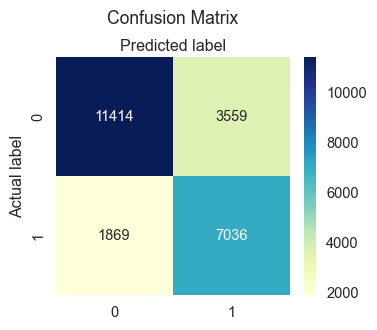

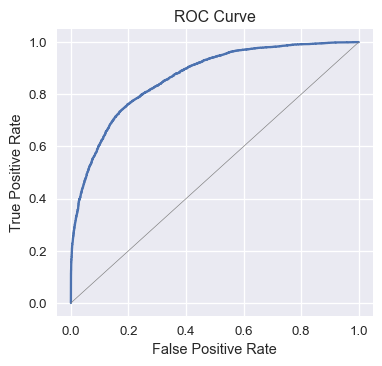

In [443]:
pred = best_log_reg.predict(X_test)
pred_proba = best_log_reg.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

#### 4.4.2 Random Forest

In [444]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=500,
                                       random_state=42)
param_grid = {'max_depth': [25],  #[15, 25],
              'min_samples_split': [2],  #[2,5],
              'min_samples_leaf': [1],  #[1,3]
              'max_features': ['auto']}  #, 15, 12, 9]}
gscv_rf = GridSearchCV(random_forest,
                       param_grid=param_grid,
                       cv=5,
                       n_jobs=-1)

gscv_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [25], 'max_features': ['auto'],
                         'min_samples_leaf': [1], 'min_samples_split': [2]})

In [445]:
best_rf = gscv_rf.best_estimator_
best_rf

RandomForestClassifier(max_depth=25, n_estimators=500, random_state=42)

Recall: 0.7788
Precision: 0.8536
Accuracy: 0.8677
F1 Score: 0.8145


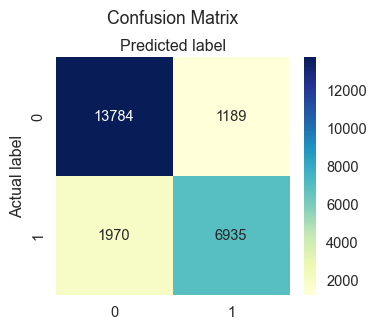

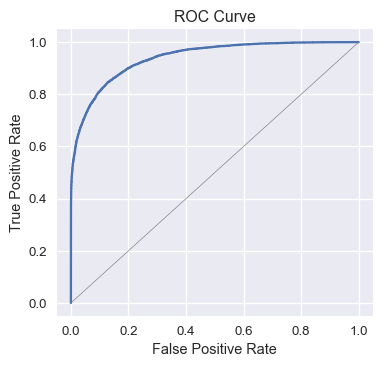

In [446]:
pred = best_rf.predict(X_test)
pred_proba = best_rf.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

In [447]:
best_rf.feature_importances_

array([0.21248043, 0.13962377, 0.06211639, 0.08416785, 0.03591058,
       0.06918747, 0.04823693, 0.06548239, 0.04255197, 0.11602778,
       0.05308652, 0.02738217, 0.04374576])

#### 4.4.3 XGBoost

In [448]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [5,7], 'min_child_weight': [1,3]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 500, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                             cv_params,
                             scoring = 'accuracy',
                             cv = 5,
                             n_jobs = -1)
optimized_GBM.fit(X_train, y_train)

C:\Users\erikf\Desktop\Master BA\S2\Machine Learning\Hotel-Booking-ML\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=N

In [449]:
best_xgb = optimized_GBM.best_estimator_

Recall: 0.7336
Precision: 0.843
Accuracy: 0.8497
F1 Score: 0.7845


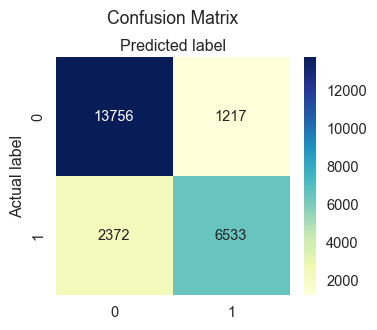

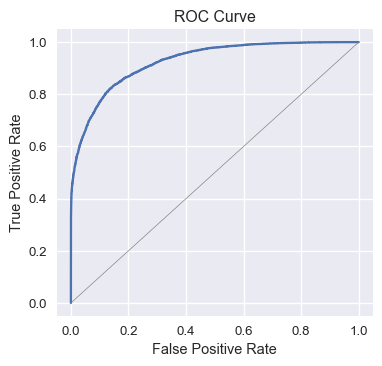

In [450]:
pred = best_xgb.predict(X_test)
pred_proba = best_xgb.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

#### 4.4.X Voting Classifier

In [451]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('lr', best_log_reg), ('rf', best_rf), ('xgb', best_xgb)],
    voting='soft')
voting_clf.fit(X_train, y_train)

C:\Users\erikf\Desktop\Master BA\S2\Machine Learning\Hotel-Booking-ML\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, class_weight='balanced',
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=25,
                                                     n_estimators=500,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.8,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-...e,
                                            interaction

Recall: 0.7784
Precision: 0.8343
Accuracy: 0.8597
F1 Score: 0.8054


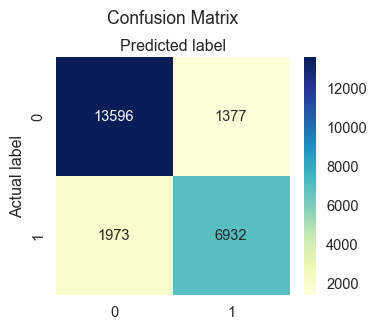

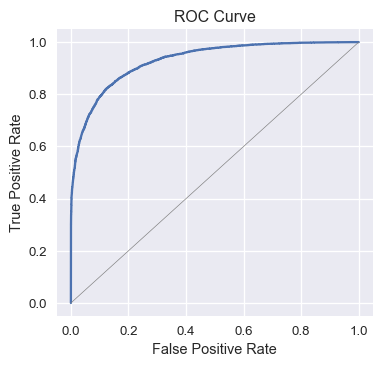

In [452]:
pred = voting_clf.predict(X_test)
pred_proba = voting_clf.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

#### 4.4.5 Artificial Neural Network

In [44]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [45]:
import tensorflow as tf
import tensorflow.keras as keras
# Run this line only in case keras_tuner is not yet installed
#!pip install -q -U keras-tuner
import keras_tuner as kt

# Defining a method that is used by the keras tuner later on
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(17,)))

    # Tune the number of units in two Dense layers
    # Choose an optimal value between 32-512
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units_1, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])

    return model

In [46]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)
tuner.search(X_train.astype('float32'), y_train.astype('float32'), epochs=50, validation_split=0.2)

Trial 30 Complete [00h 02m 03s]
val_accuracy: 0.8177154660224915

Best val_accuracy So Far: 0.8199664950370789
Total elapsed time: 00h 24m 25s
INFO:tensorflow:Oracle triggered exit


In [47]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, for the second densely-connected layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288, for the second densely-connected layer is 160 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
ann = tuner.hypermodel.build(best_hps)
history = ann.fit(X_train.astype('float32'), 
                    y_train.astype('float32'), 
                    epochs=50, 
                    validation_split=0.2)


2022-05-02 15:01:32.805113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Recall: 0.7047
Precision: 0.8081
Accuracy: 0.8275
F1 Score: 0.7528


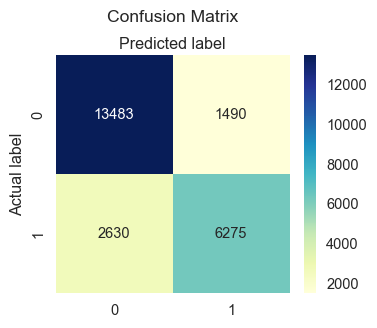

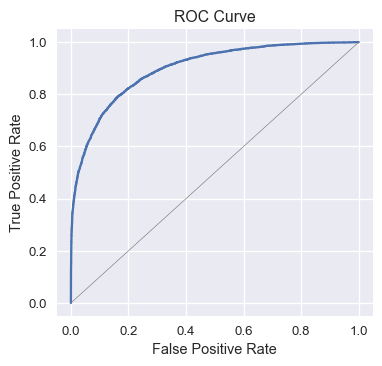

In [55]:
pred_proba = ann.predict(X_test.astype('float32'))[:,1]
pred = np.where(pred_proba > 0.5, 1,0)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve_ann(y_test, pred_proba)


### 4.5 Model Comparison
In order to compare the different models developed before, a table comparing each of the obtained classification evaluation metrics is created.

In [56]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

models = [best_log_reg, best_rf, best_xgb, voting_clf, ann]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
for model in models:
    
    if model == ann:
        pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        model_pred = np.where(pred_proba > 0.5, 1,0)
        
    else:
        model_pred = model.predict(X_test)
        
    accuracy = round(accuracy_score(y_test, model_pred), 4)
    recall = round(recall_score(y_test, model_pred), 4)
    precision = round(precision_score(y_test, model_pred), 4)
    f1 = round(f1_score(y_test, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model.__class__.__name__])
    comparison_df = comparison_df.join(model_statistics)
comparison_df

,LogisticRegression,RandomForestClassifier,XGBClassifier,VotingClassifier,Sequential
Accuracy,0.7824,0.8672,0.8469,0.8524,0.8275
Precision,0.6762,0.8541,0.8385,0.8225,0.8081
Recall,0.7993,0.7765,0.7300,0.7705,0.7047
F1 Score,0.7326,0.8135,0.7805,0.7956,0.7528


We can see that the Random Forest model is the best model in for every metric except for recall (Logistic Regression performs best) and even outperforms the Voting Classifier

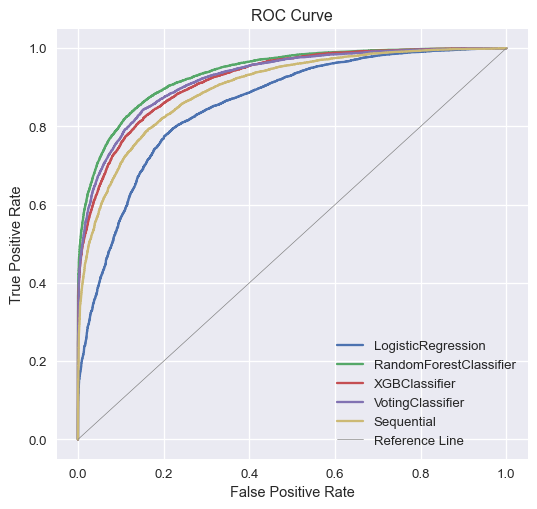

In [57]:
get_roc_curve_multiple(models, X_test, y_test)

The ROC curves for all models look very well balanced towards the top left corner - as expected, the Random Forest Classifier also performs best in this aspect.

In [455]:
### TO BE DELETED BEFORE SUBMISSION
# used for trials with models / features

#base_case_metrics = comparison_df.copy()
#base_case_metrics.to_csv('base_case_metrics.csv')
base_case_metrics = pd.read_csv('base_case_metrics.csv', index_col=0)
comparison_df - base_case_metrics

,LogisticRegression,RandomForestClassifier,XGBClassifier,VotingClassifier
Accuracy,0.0009,0.0026,0.0095,0.0090
Precision,0.0067,0.0021,0.0130,0.0148
Recall,-0.0202,0.0058,0.0149,0.0092
F1 Score,-0.0043,0.0041,0.0142,0.0118


### 4.6 Loading and saving of models

In [53]:
# Saving models

import joblib
# save the model to disk
models_to_save = [best_log_reg, best_rf, best_xgb, voting_clf, ann]
all_filenames = []

for model in models_to_save:
    if model == ann:
        ann.save('ann')
    else: 
        label = model.__class__.__name__
        filename = label + '.sav'
        all_filenames.append(filename)
        joblib.dump(model, filename)
        print(label + " saved")
joblib.dump(all_filenames ,"filenames.sav")
print('\nall models saved')

# Loading the model again if needed
#ann = tf.keras.models.load_model('ANN_model1')

LogisticRegression saved
RandomForestClassifier saved
XGBClassifier saved
VotingClassifier saved
INFO:tensorflow:Assets written to: ann/assets
ann saved

all models saved


2022-05-02 15:00:50.226287: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [168]:
# Loading Models

all_filenames = joblib.load("filenames.sav")

best_log_reg = joblib.load(all_filenames[0])
best_rf = joblib.load(all_filenames[1])
best_xgb = joblib.load(all_filenames[2])
voting_clf = joblib.load(all_filenames[3])
ann = tf.keras.models.load_model('ann')


## 6. Business Case Calculation

### 6.1 simple day based model

In [204]:
import datetime
df_eval_train = df_all[df_all['arrival_date'] < datetime.datetime(2017, 7, 1)]
df_eval_test = df_all[df_all['arrival_date'] >= datetime.datetime(2017, 7, 1)]
print(df_eval_train.shape)
print(df_eval_test.shape)

(109148, 42)
(10238, 42)


In [205]:
clustering_pipeline.fit(df_eval_train)
df_eval_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
df_eval_train['customer_cluster'] = df_eval_train['customer_cluster'].astype(str)
df_eval_test['customer_cluster'] = clustering_pipeline.predict(df_eval_test)
df_eval_test['customer_cluster'] = df_eval_test['customer_cluster'].astype(str)

X_train_eval = preprocessor.fit_transform(df_eval_train)
y_train_eval = df_eval_train['is_canceled']
X_test_eval = preprocessor.transform(df_eval_test)
y_test_eval = df_eval_test['is_canceled']

best_rf.fit(X_train_eval, y_train_eval)
y_pred_eval = best_rf.predict(X_test_eval)
df_eval_test['is_canceled_predicted'] = y_pred_eval

- If booking is canceled and we predict it correctly: + ADR from that booking
- The False Positives and Negatives are summed up per day

In [211]:
df_profit = df_eval_test[['is_canceled', 'is_canceled_predicted', 'arrival_date','adr']]
df_profit['correctly_classified'] = np.where((df_profit['is_canceled'] == df_profit['is_canceled_predicted']),
                                             1,
                                             0)
df_profit['additional_adr'] = np.where((df_profit['is_canceled'] == 1) & (df_profit['correctly_classified'] == 1), 
                                       df_profit['adr'],
                                       0) * 0.8
display(df_profit)
average_adr = df_profit.adr.mean()

df_profit_agg = df_profit.groupby('arrival_date').sum()
df_profit_agg['neg_adr_overbooking'] = df_profit_agg['is_canceled_predicted'] - df_profit_agg['is_canceled']
df_profit_agg['neg_adr_overbooking'] = np.where(df_profit_agg['neg_adr_overbooking'] < 0, 
                                                0, 
                                                df_profit_agg['neg_adr_overbooking'])
df_profit_agg['neg_adr_overbooking'] *= average_adr * 1.2
df_profit_agg

,is_canceled,is_canceled_predicted,arrival_date,adr,correctly_classified,additional_adr
12459,1,0,2017-07-01,138.40,0,0.0
12460,1,0,2017-07-01,120.00,0,0.0
12461,1,0,2017-07-01,93.38,0,0.0
12462,1,1,2017-07-01,250.00,1,200.0
12463,1,0,2017-07-01,93.38,0,0.0
...,...,...,...,...,...,...
119385,0,0,2017-08-30,96.14,1,0.0
119386,0,0,2017-08-31,225.43,1,0.0
119387,0,0,2017-08-31,157.71,1,0.0
119388,0,1,2017-08-31,104.40,0,0.0


,is_canceled,is_canceled_predicted,adr,correctly_classified,additional_adr,neg_adr_overbooking
arrival_date,,,,,,
2017-07-01,70,57,23969.89,123,3339.776,0.0
2017-07-02,54,45,19949.72,83,2150.752,0.0
2017-07-03,64,50,24450.40,124,4022.400,0.0
2017-07-04,51,36,23334.47,165,2424.832,0.0
2017-07-05,68,34,17812.46,82,2412.736,0.0
...,...,...,...,...,...,...
2017-08-27,49,34,26631.01,125,2227.216,0.0
2017-08-28,64,40,31920.42,153,3180.200,0.0
2017-08-29,44,27,18081.93,88,1835.664,0.0


In [202]:
round(df_profit_agg.additional_adr.sum() - df_profit_agg.neg_adr_overbooking.sum(),2)

201180.38

In [212]:
df_profit.groupby('arrival_date').sum()

,is_canceled,is_canceled_predicted,adr,correctly_classified,additional_adr
arrival_date,,,,,
2017-07-01,70,57,23969.89,123,3339.776
2017-07-02,54,45,19949.72,83,2150.752
2017-07-03,64,50,24450.40,124,4022.400
2017-07-04,51,36,23334.47,165,2424.832
2017-07-05,68,34,17812.46,82,2412.736
...,...,...,...,...,...
2017-08-27,49,34,26631.01,125,2227.216
2017-08-28,64,40,31920.42,153,3180.200
2017-08-29,44,27,18081.93,88,1835.664


In [202]:
round(df_profit_agg.additional_adr.sum() - df_profit_agg.neg_adr_overbooking.sum(),2)

201180.38

Recall: 0.4397
Precision: 0.6719
Accuracy: 0.7123
F1 Score: 0.5316


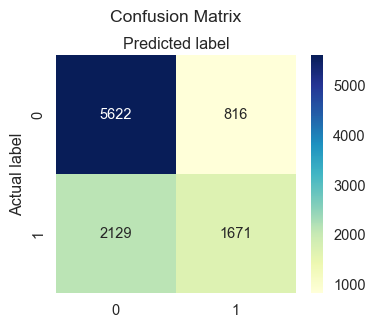

In [214]:
get_cnf_matrix(df_eval_test['is_canceled'], df_eval_test['is_canceled_predicted'])
get_metrics(df_eval_test['is_canceled'], df_eval_test['is_canceled_predicted'])

## 5. Appendix

### 5.1 ADR per Person
We've seen that both the number of persons and the adr are features that influence whether a booking is cancelled or not. At the same time, adr is highly correlated with group size. Let's see if calculating the adr per person helps to explain cancellations as it removes the information captured in group size already.

First, we construct different versions of the adr per person: One per guest (including babies and children) and one per adult. This way we ensure to test whether the pricing structure of the hotel also reflects whether children or babies are part of the guests.

In [49]:
df_adr = df.copy()
df_adr['adults'].replace({0: df_adr['adults'].median()}, inplace=True)
df_adr['guests'].replace({0: df_adr['guests'].median()}, inplace=True)
df_adr['adr_per_guest'] = df_adr['adr'] / df_adr['guests']
df_adr['adr_per_adult'] = df_adr['adr'] / df_adr['adults']

Let's see the correlation with is_cancelled for all versions and the original adr...

In [50]:
df_adr[['adr', 'adr_per_guest', 'adr_per_adult', 'is_canceled']].corr()['is_canceled']

adr              0.045862
adr_per_guest    0.021409
adr_per_adult    0.021024
is_canceled      1.000000
Name: is_canceled, dtype: float64

Unfortunately, the adr per person does not help us more in explaining cancellations than the group adr does.

### 5.2 K-Means clustering of customers
In 3.2, it is striking that only few of the categorical features that depict the type of customer, such as the room in which they stay, the meal ordered, or the group size are part of the top 15 features. Let's have a closer look at how these features ranked in the recursive feature elimination:

In [481]:
customer_attribs = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'distribution_channel', 'customer_type', 'is_repeated_guest']
feat_rank_names = feat_rank_df.index.tolist()
customer_attribs_mask = [any(customer_attrib in feat_name for customer_attrib in customer_attribs) for feat_name in feat_rank_names]
feat_rank_df[customer_attribs_mask]

,rank
categorical__customer_type_Transient,1
numeric__stay_total_nights,1
categorical__customer_type_Transient-Party,2
categorical__hotel_Resort Hotel,3
categorical__meal_BB,3
categorical__distribution_channel_TA/TO,3
categorical__reserved_room_type_A,4
categorical__hotel_City Hotel,4
categorical__meal_HB,5
categorical__distribution_channel_Direct,5


Only 2 of the customer characteristics made it into the top 15. The rest got kicked out pretty early. The reason for this could be that these features contain that many sub-categories, that each sole subcategory does not explain cancellations sufficiently. There might still be the possibility that combined, these features *do* actually have relevance. In the following, we test this possibility by clustering customers based on their characteristics such as room type or meal and test, whether these clusters help to predict cancellations.

First, we binarize the categorical features:

In [482]:
cluster_df = df[customer_attribs]
cluster_df

,guests,reserved_room_type,meal,stay_total_nights,is_family,hotel,distribution_channel,customer_type,is_repeated_guest
67705,1,A,BB,3,0,City Hotel,TA/TO,Transient,0
115852,4,E,BB,2,1,City Hotel,Direct,Transient,0
57349,2,A,HB,2,0,City Hotel,TA/TO,Transient,0
11622,2,E,BB,6,0,Resort Hotel,Direct,Transient,0
33333,2,D,BB,2,0,Resort Hotel,TA/TO,Transient,0
...,...,...,...,...,...,...,...,...,...
76824,3,A,BB,1,1,City Hotel,TA/TO,Transient,1
110272,2,A,SC,3,0,City Hotel,TA/TO,Transient,0
103698,3,E,BB,3,0,City Hotel,TA/TO,Transient,0
860,2,A,BB,7,0,Resort Hotel,TA/TO,Transient,0


In [483]:
cols_to_binarize = cluster_df.columns[cluster_df.dtypes == 'object'].tolist()
for col in cols_to_binarize:
    dummy_cols = pd.get_dummies(cluster_df[col], prefix=col)
    cluster_df = pd.concat([cluster_df, dummy_cols], axis=1)
cluster_df.drop(columns=cols_to_binarize, axis=1, inplace=True)
cluster_df

,guests,stay_total_nights,is_family,is_repeated_guest,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,hotel_City Hotel,hotel_Resort Hotel,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
67705,1,3,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
115852,4,2,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
57349,2,2,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
11622,2,6,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
33333,2,2,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76824,3,1,1,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
110272,2,3,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
103698,3,3,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
860,2,7,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


Next, we try different cluster sizes from 2 to 10 and observe the silhouette score obtained for each k:

100%|██████████| 9/9 [18:45<00:00, 125.09s/it]


Text(0.5, 1.0, 'Silhouette Scores for Variations of k')

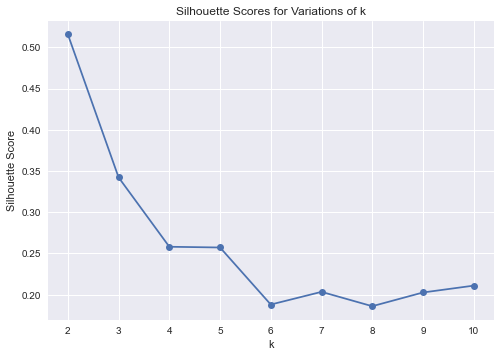

In [492]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

scores = []
k_min = 2
k_max = 10
k_range = range(k_min, k_max+1)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(cluster_df)
    labels = kmeans.labels_
    score = silhouette_score(cluster_df, labels, metric = 'euclidean')
    scores.append(score)
plt.plot(k_range, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Variations of k')

The resulting silhouette score is highest for k=2. This though would not help us much, since the resulting clusters would very likely only be split between city and resort hotel. Thus, we want to choose a higher k, that can reflect differences within each hotel type as well. In the following, we'll work with k=4.

In order to understand the resulting clusters better, we can look at their sizes and the 'median customer' of each:

In [547]:
kmeans = KMeans(n_clusters=4, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
pd.DataFrame(data=[pd.Series(kmeans.labels_).value_counts(), pd.Series(kmeans.labels_).value_counts(normalize=True)], index=['count', 'relative']).T

,count,relative
3,41740.0,0.437031
0,39571.0,0.414321
1,12820.0,0.134230
2,1377.0,0.014418


More than 80% of the customers are clustered in the top 2 clusters. The remaining clusters are very small, especially cluster 2 with only 1.4%.

Let's have a look at how the median customer per cluster looks like:

In [520]:
cluster_df['predicted_cluster'] = kmeans.labels_
cluster_df.groupby('predicted_cluster').median()

,guests,stay_total_nights,is_family,is_repeated_guest,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,hotel_City Hotel,hotel_Resort Hotel,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
predicted_cluster,,,,,,,,,,,,,,,,,,,,,
0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [574]:
clusters = cluster_df['predicted_cluster'].unique()
for cluster in clusters:
    cluster_data = cluster_df[cluster_df['predicted_cluster'] == cluster]
    percent_of_total = cluster_data.shape[0] / cluster_df.shape[0]
    print(f"Cluster {cluster} ({round(percent_of_total*100, 2)}% of total):")
    for col in [c for c in cluster_data.columns if c != 'predicted_cluster']:
        count = cluster_data[col].value_counts(normalize=True)
        top_count = count.nlargest(1)
        print(f"\t{col}: {top_count.index[0]} ({int(round(top_count.values[0]*100,0))}%)")

Cluster 1 (41.39% of total):
	guests: 2 (73%)
	stay_total_nights: 3 (55%)
	is_family: 0 (92%)
	is_repeated_guest: 0 (99%)
	reserved_room_type_A: 1 (73%)
	reserved_room_type_B: 0 (99%)
	reserved_room_type_C: 0 (100%)
	reserved_room_type_D: 0 (83%)
	reserved_room_type_E: 0 (96%)
	reserved_room_type_F: 0 (98%)
	reserved_room_type_G: 0 (99%)
	reserved_room_type_H: 0 (100%)
	reserved_room_type_L: 0 (100%)
	reserved_room_type_P: 0 (100%)
	meal_BB: 1 (80%)
	meal_FB: 0 (99%)
	meal_HB: 0 (92%)
	meal_SC: 0 (90%)
	meal_Undefined: 0 (99%)
	hotel_City Hotel: 1 (79%)
	hotel_Resort Hotel: 0 (79%)
	distribution_channel_Corporate: 0 (97%)
	distribution_channel_Direct: 0 (91%)
	distribution_channel_GDS: 0 (100%)
	distribution_channel_TA/TO: 1 (88%)
	customer_type_Contract: 0 (98%)
	customer_type_Group: 0 (100%)
	customer_type_Transient: 1 (76%)
	customer_type_Transient-Party: 0 (79%)
Cluster 0 (41.43% of total):
	guests: 2 (63%)
	stay_total_nights: 2 (56%)
	is_family: 0 (94%)
	is_repeated_guest: 0 (94%)

Next, we need to understand whether the clustering will improve our model performance. For simplicity, we only take the current best working model (Random Forest) and compare the obtained scores.

First, we construct the pipeline for k-means clustering:

In [587]:
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

cluster_numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cluster_binary_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

cluster_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

clustering_preprocessing = ColumnTransformer(
    transformers=[
        ('num', cluster_numeric_transformer, cust_cluster_attribs_num),
        ('cat', cluster_categorical_transformer, cust_cluster_attribs_cat),
        ('binary', cluster_binary_transformer, cust_cluster_attribs_bin)
    ]
)

clustering_pipeline = Pipeline(
    steps=[
        ('preprocessor', clustering_preprocessing),
        ('kmeans', KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=seed))
    ]
)

clustering_pipeline.fit(df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['guests',
                                                   'stay_total_nights']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
  

Then we enrich the train set with clusters resulting from the previously constructed and fitted pipeline, and the test set with the predicted clusters from that pipeline:

In [588]:
df_cluster_performance_train = df.copy()
df_cluster_performance_test = df_test.copy()
df_cluster_performance_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
df_cluster_performance_test['customer_cluster'] = clustering_pipeline.predict(df_cluster_performance_test)
#df_cluster_performance_train['customer_cluster'] = kmeans.labels_
#df_cluster_performance_test['customer_cluster'] = kmeans.predict(truncator.transform(clustering_preprocessing.fit_transform(df_cluster_performance_test)))

In order to compare the models, we need to include the customer clusters in our preprocessing pipeline. We do this by appending a pipeline that one-hot-encodes the clusters:

In [589]:
transformers = preprocessor.transformer_list.copy()

cluster_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(['customer_cluster'])),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)
transformers.append(('cluster_pipeline', cluster_pipeline))
preprocessor_w_clustering = FeatureUnion(transformers)

Ready to go. Now we can get the train and test set and compare the performance of a model with and without customer clusters.

In [590]:
X_train_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_train)
y_train_cluster = df_cluster_performance_train['is_canceled']

X_test_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_test)
y_test_cluster = df_cluster_performance_test['is_canceled']

In [595]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.base import clone

rf_original = clone(best_rf).fit(X_train, y_train)
rf_cluster = clone(best_rf).fit(X_train_cluster, y_train_cluster)

models = [rf_original, rf_cluster]
model_names = ['Original', 'With Clusters']
model_test_sets = [(X_test, y_test), (X_test_cluster, y_test_cluster)]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
for i, model in enumerate(models):
    model_pred = model.predict(model_test_sets[i][0])
    model_y_test = model_test_sets[i][1]
    accuracy = round(accuracy_score(model_y_test, model_pred), 4)
    recall = round(recall_score(model_y_test, model_pred), 4)
    precision = round(precision_score(model_y_test, model_pred), 4)
    f1 = round(f1_score(model_y_test, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model_names[i]])
    comparison_df = comparison_df.join(model_statistics)
comparison_df

,Original,With Clusters
Accuracy,0.8677,0.8702
Precision,0.8536,0.8558
Recall,0.7788,0.7841
F1 Score,0.8145,0.8184


The model performance increased very, very slightly.

Let's have a look at how important the clusters are for the predictions:

In [596]:
print(f"Importances: {rf_cluster.feature_importances_[-4:]}")
print(f"Total: {round(sum(rf_cluster.feature_importances_[-4:])*100, 1)}%")

Importances: [0.00722549 0.0105566  0.00461831 0.00429477]
Total: 2.7%


Each of the resulting clusters added low importance (<=1%) to the model. Altogether, the clusters account for only ~2.7% of the model's feature importances.

**Conclusion for Customer Clusters:**
<br>Clustering the customers into clusters only helps to improve the model performance very slightly. At the same time, it adds additional computation time and complexity. Considering this, we will refrain from using customer clusters as features in the final model.